In [1]:
import os
import pandas as pd
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as tx
import torchvision.transforms as T
import numpy as np
from torch import nn
from torchmetrics import Accuracy
from PIL import Image
import random

In [2]:
global_mean = [158.3856573864422, 114.90580952062017, 95.67717047497234]
global_std = [37.309381112669854, 36.328787789451965, 35.34503472225006]

In [3]:
class Mydataset():
    def __init__(self, csv_file, augment=False):
        self.df = pd.read_csv("../data/"+csv_file)
        self.augment = augment
        self.image_size = 256
        self.mean = np.array(global_mean)
        self.std = np.array(global_std)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        image_id = self.df["id"][idx]
        label = self.df["label"][idx]
        image = cv2.imread("../data/crop_nail_image/"+image_name)
        image = cv2.resize(image, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.augment:
            image = augmentation(image)
        image = tx.to_tensor(image)
        image = tx.resize(image, (self.image_size, self.image_size))
        image = tx.normalize(image, self.mean/255, self.std/255) 
        return image, label

In [4]:
def augmentation(image):
    #color jitter
    threshold = 0.2
    if(random.random()>threshold):
        jitter = T.ColorJitter(brightness=.5, hue=.3)
        image = jitter(image)



    #Gaussian blur
    if(random.random()>threshold):
        blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        image = blurrer(image)



    #Perspective
    if(random.random()>threshold):
        perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
        image = perspective_transformer(image)


    #Rotation
    if(random.random()>threshold):
        random_degree = random.randint(0, 8) * 45
        image = tx.rotate(image, random_degree)




    #Affine
    if(random.random()>threshold):
        affine_transfomer = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
        image = affine_transfomer(image)



    #Invert
    if(random.random()>threshold):
        inverter = T.RandomInvert()
        image = inverter(image)

    #Posterize
    if(random.random()>threshold):
        posterizer = T.RandomPosterize(bits=2)
        image = posterizer(image)



    #Solarize
    if(random.random()>threshold):
        solarizer = T.RandomSolarize(threshold=192.0)
        image = solarizer(image)


    #AdjustSharpness
    if(random.random()>threshold):
        sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=1)
        image = sharpness_adjuster(image)



    #Equalize
    if(random.random()>threshold):
        equalizer = T.RandomEqualize()
        image = equalizer(image)
        
    if(random.random()>threshold):
        cropper = T.RandomCrop(size=(128, 128))
        image = cropper(image) 


    return image

In [5]:
train_dataset = Mydataset("train_csv", augment=True)
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle=True)
valid_dataset = Mydataset("valid_csv", augment=False)
valid_dataloader = DataLoader(valid_dataset, batch_size = 8)

In [6]:
!nvidia-smi

Sat Dec 24 23:34:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.25       Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 64%   69C    P3    91W / 350W |     81MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
image, label = next(iter(train_dataloader))

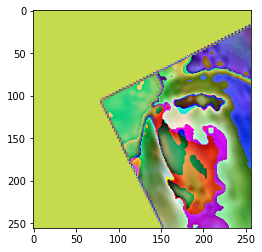

tensor(0)


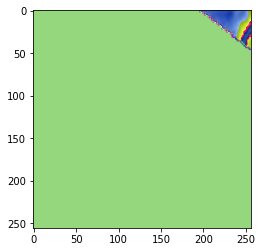

tensor(1)


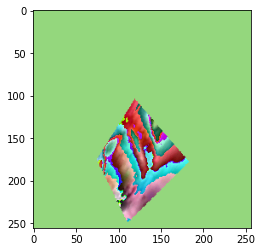

tensor(0)


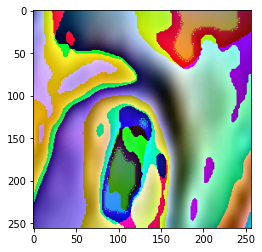

tensor(1)


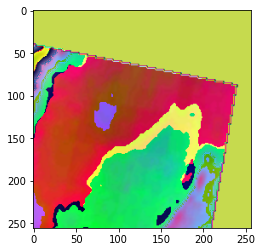

tensor(0)


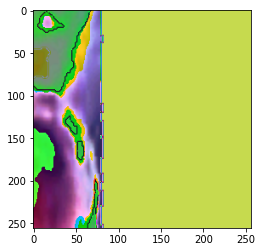

tensor(0)


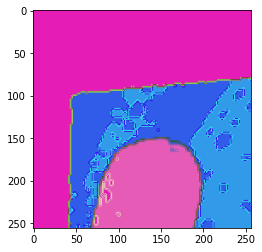

tensor(1)


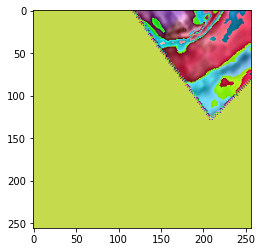

tensor(0)


In [8]:
transform = T.ToPILImage()
for i in range(image.shape[0]):
    img = transform(image[i])
    plt.imshow(img)
    plt.show()
    print(label[i])
#     break

In [9]:
model = torchvision.models.efficientnet_b6(pretrained=True)
model.classifier = torch.nn.Linear(2304, 2, bias=True)

In [10]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
criterion = Accuracy(task="multiclass", num_classes=40).to(device)
origin_lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=origin_lr)

print(device)

cuda


In [11]:
def get_score(pred, label):
    pred = torch.argmax(pred, axis = 1)
    score = 0
    for i in range(len(pred)):
        if pred[i]==label[i]:
            score+=1

    return score

In [12]:

def train(dataloader, optimizer, loss_fn, model):
    model.train()
    total_loss = 0
    total_acc = 0
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        image = image.requires_grad_()
        pred = model(image)
        loss = loss_fn(pred, label)
        acc = get_score(pred, label)
        total_loss += loss.item()
        total_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%200==0:
            print("train average total loss : ", total_loss/(i+1))
    return total_loss, total_acc
def valid(dataloader, loss_fn, model):
    model.eval()
    total_loss = 0
    total_acc = 0
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        loss = loss_fn(pred, label)
        acc = get_score(pred, label)
        total_loss += loss.item()
        total_acc += acc
        if i%200==0:
            print("valid average total loss : ", total_loss/(i+1))
    return total_loss, total_acc

In [ ]:
model = model.to(device)
max_score = 0
if not os.path.exists("../data/models"):
    os.mkdir("../data/models")
not_improve = 0
lr = origin_lr
date = "12_24_5"
for i in range(5000):
    print("epoch : ", i)
    train_loss, train_acc = train(train_dataloader, optimizer, loss_fn, model)
    print("train epoch loss : ",train_loss/len(train_dataloader))
    print("train epoch acc : ",train_acc/len(train_dataset))
    with torch.no_grad():
        valid_loss, valid_acc = valid(valid_dataloader, loss_fn, model)
        print("valid epoch loss : ",valid_loss/len(valid_dataloader))
        print("valid epoch acc : ",valid_acc/len(valid_dataset))
        if valid_acc/len(valid_dataset)>max_score:
            not_improve = 0
            max_score = valid_acc/len(valid_dataset)
            torch.save(model.state_dict(), "../data/models/"+date+"best.pth")
            print("###############################save best model###############################")
        else:
            not_improve+=1
            if not_improve==200:
                print("############reduce lr#############")
                not_improve = 0
                lr/=2
                for g in optimizer.param_groups:
                    g['lr'] = lr

epoch :  0
train average total loss :  0.7064350247383118
train epoch loss :  0.7234247643120435
train epoch acc :  0.509090909090909
valid average total loss :  0.6727140545845032
valid epoch loss :  0.7054813437991672
valid epoch acc :  0.5074626865671642
###############save best model####################
epoch :  1
train average total loss :  0.6482989192008972
train epoch loss :  0.7188714243927781
train epoch acc :  0.5428571428571428
valid average total loss :  0.7272855639457703
valid epoch loss :  0.7198106381628249
valid epoch acc :  0.47761194029850745
epoch :  2
train average total loss :  0.8989906311035156
train epoch loss :  0.7214580676993545
train epoch acc :  0.4857142857142857
valid average total loss :  0.7883358001708984
valid epoch loss :  0.6921741101476881
valid epoch acc :  0.4925373134328358
epoch :  3
train average total loss :  0.6062126159667969
train epoch loss :  0.7081983430044991
train epoch acc :  0.4857142857142857
valid average total loss :  0.7109317

train average total loss :  0.6934844255447388
train epoch loss :  0.6956093299145601
train epoch acc :  0.5012987012987012
valid average total loss :  0.6999795436859131
valid epoch loss :  0.6917321880658468
valid epoch acc :  0.5074626865671642
epoch :  32
train average total loss :  0.6795790195465088
train epoch loss :  0.6974547724334561
train epoch acc :  0.5038961038961038
valid average total loss :  0.6704134345054626
valid epoch loss :  0.6977113816473219
valid epoch acc :  0.5373134328358209
epoch :  33
train average total loss :  0.6655486226081848
train epoch loss :  0.6947081174169268
train epoch acc :  0.5246753246753246
valid average total loss :  0.7045131325721741
valid epoch loss :  0.7031315962473551
valid epoch acc :  0.5074626865671642
epoch :  34
train average total loss :  0.7281840443611145
train epoch loss :  0.6940324720071287
train epoch acc :  0.5272727272727272
valid average total loss :  0.6977472901344299
valid epoch loss :  0.6980127625995212
valid epoc

valid epoch loss :  0.6851311789618598
valid epoch acc :  0.5373134328358209
epoch :  63
train average total loss :  0.6462484002113342
train epoch loss :  0.6963922624685326
train epoch acc :  0.5246753246753246
valid average total loss :  0.6943598389625549
valid epoch loss :  0.6946566104888916
valid epoch acc :  0.4925373134328358
epoch :  64
train average total loss :  0.6934347748756409
train epoch loss :  0.6945619972384706
train epoch acc :  0.5194805194805194
valid average total loss :  0.6872087717056274
valid epoch loss :  0.699704216586219
valid epoch acc :  0.5223880597014925
epoch :  65
train average total loss :  0.6268882751464844
train epoch loss :  0.6933604369358141
train epoch acc :  0.5064935064935064
valid average total loss :  0.6921238899230957
valid epoch loss :  0.7027107808325026
valid epoch acc :  0.4626865671641791
epoch :  66
train average total loss :  0.70772784948349
train epoch loss :  0.6910938219148286
train epoch acc :  0.548051948051948
valid avera

train epoch loss :  0.6919201101575579
train epoch acc :  0.5272727272727272
valid average total loss :  0.7136595845222473
valid epoch loss :  0.6993268198437161
valid epoch acc :  0.5074626865671642
epoch :  95
train average total loss :  0.7024928331375122
train epoch loss :  0.6907681044267149
train epoch acc :  0.5298701298701298
valid average total loss :  0.6948500871658325
valid epoch loss :  0.6970322529474894
valid epoch acc :  0.5074626865671642
epoch :  96
train average total loss :  0.7227293252944946
train epoch loss :  0.6916300471948118
train epoch acc :  0.535064935064935
valid average total loss :  0.6879722476005554
valid epoch loss :  0.6910961601469252
valid epoch acc :  0.5522388059701493
epoch :  97
train average total loss :  0.7233189344406128
train epoch loss :  0.6992926719237347
train epoch acc :  0.5116883116883116
valid average total loss :  0.6990700364112854
valid epoch loss :  0.7008282873365614
valid epoch acc :  0.4925373134328358
epoch :  98
train av

valid epoch loss :  0.6937970651520623
valid epoch acc :  0.5074626865671642
epoch :  126
train average total loss :  0.7070738077163696
train epoch loss :  0.6944093825865765
train epoch acc :  0.5298701298701298
valid average total loss :  0.6994636058807373
valid epoch loss :  0.6956311596764458
valid epoch acc :  0.5074626865671642
epoch :  127
train average total loss :  0.6855171918869019
train epoch loss :  0.6909842527642542
train epoch acc :  0.535064935064935
valid average total loss :  0.7002604007720947
valid epoch loss :  0.6974801884757148
valid epoch acc :  0.5074626865671642
epoch :  128
train average total loss :  0.7047083377838135
train epoch loss :  0.6921739566082857
train epoch acc :  0.5298701298701298
valid average total loss :  0.6964676380157471
valid epoch loss :  0.6965156594912211
valid epoch acc :  0.5074626865671642
epoch :  129
train average total loss :  0.687858521938324
train epoch loss :  0.6896489128774527
train epoch acc :  0.5298701298701298
valid

train epoch loss :  0.6926058980883384
train epoch acc :  0.5324675324675324
valid average total loss :  0.694786012172699
valid epoch loss :  0.6951710846689012
valid epoch acc :  0.5074626865671642
epoch :  158
train average total loss :  0.7293563485145569
train epoch loss :  0.6934427825772033
train epoch acc :  0.5376623376623376
valid average total loss :  0.7004404664039612
valid epoch loss :  0.7003124687406752
valid epoch acc :  0.5074626865671642
epoch :  159
train average total loss :  0.6774497032165527
train epoch loss :  0.6935555411844837
train epoch acc :  0.5376623376623376
valid average total loss :  0.694785475730896
valid epoch loss :  0.6964647637473212
valid epoch acc :  0.5074626865671642
epoch :  160
train average total loss :  0.714894711971283
train epoch loss :  0.6916268966635879
train epoch acc :  0.535064935064935
valid average total loss :  0.6943250298500061
valid epoch loss :  0.6952154106563992
valid epoch acc :  0.5074626865671642
epoch :  161
train a

valid epoch loss :  0.694989886548784
valid epoch acc :  0.5074626865671642
epoch :  189
train average total loss :  0.672248125076294
train epoch loss :  0.6910012875284467
train epoch acc :  0.5298701298701298
valid average total loss :  0.6960501670837402
valid epoch loss :  0.6958326167530484
valid epoch acc :  0.5074626865671642
epoch :  190
train average total loss :  0.7120668292045593
train epoch loss :  0.6908815795061539
train epoch acc :  0.5324675324675324
valid average total loss :  0.6942256689071655
valid epoch loss :  0.6934733390808105
valid epoch acc :  0.5074626865671642
epoch :  191
train average total loss :  0.7045259475708008
train epoch loss :  0.692982017993927
train epoch acc :  0.5324675324675324
valid average total loss :  0.7273892164230347
valid epoch loss :  0.705125802093082
valid epoch acc :  0.5074626865671642
epoch :  192
train average total loss :  0.7403674721717834
train epoch loss :  0.6923564185901564
train epoch acc :  0.5246753246753246
valid a

train average total loss :  0.7131603360176086
train epoch loss :  0.6911624110474879
train epoch acc :  0.5324675324675324
valid average total loss :  0.692345142364502
valid epoch loss :  0.695685002538893
valid epoch acc :  0.5074626865671642
epoch :  221
train average total loss :  0.7004024982452393
train epoch loss :  0.6936810904619645
train epoch acc :  0.5272727272727272
valid average total loss :  0.6928685903549194
valid epoch loss :  0.6955779989560446
valid epoch acc :  0.5074626865671642
epoch :  222
train average total loss :  0.6951819658279419
train epoch loss :  0.6916152469965876
train epoch acc :  0.5324675324675324
valid average total loss :  0.6911292672157288
valid epoch loss :  0.6964390873908997
valid epoch acc :  0.5074626865671642
epoch :  223
train average total loss :  0.7032299041748047
train epoch loss :  0.6910891155807339
train epoch acc :  0.5272727272727272
valid average total loss :  0.6934401988983154
valid epoch loss :  0.6963820589913262
valid epo

valid epoch loss :  0.6953850984573364
valid epoch acc :  0.5074626865671642
epoch :  252
train average total loss :  0.6670236587524414
train epoch loss :  0.6930350345008227
train epoch acc :  0.5298701298701298
valid average total loss :  0.6962621808052063
valid epoch loss :  0.6958494981129965
valid epoch acc :  0.5074626865671642
epoch :  253
train average total loss :  0.7089342474937439
train epoch loss :  0.6931330245368335
train epoch acc :  0.5324675324675324
valid average total loss :  0.6957976222038269
valid epoch loss :  0.6953363219896952
valid epoch acc :  0.5074626865671642
epoch :  254
train average total loss :  0.7094449400901794
train epoch loss :  0.6894127252150555
train epoch acc :  0.5324675324675324
valid average total loss :  0.7044984698295593
valid epoch loss :  0.6911266777250502
valid epoch acc :  0.6119402985074627
epoch :  255
train average total loss :  0.7077839374542236
train epoch loss :  0.6917753170947639
train epoch acc :  0.5376623376623376
val

train epoch loss :  0.6922757881028312
train epoch acc :  0.5324675324675324
valid average total loss :  0.6943864822387695
valid epoch loss :  0.6949407921897041
valid epoch acc :  0.5074626865671642
epoch :  284
train average total loss :  0.6925146579742432
train epoch loss :  0.690794942330341
train epoch acc :  0.5324675324675324
valid average total loss :  0.6948001980781555
valid epoch loss :  0.6952902674674988
valid epoch acc :  0.5074626865671642
epoch :  285
train average total loss :  0.6934996843338013
train epoch loss :  0.6928758779350592
train epoch acc :  0.5324675324675324
valid average total loss :  0.6934791207313538
valid epoch loss :  0.6981134215990702
valid epoch acc :  0.5074626865671642
epoch :  286
train average total loss :  0.7108969688415527
train epoch loss :  0.6927647992056243
train epoch acc :  0.5324675324675324
valid average total loss :  0.6909958720207214
valid epoch loss :  0.6995276874966092
valid epoch acc :  0.5074626865671642
epoch :  287
trai

train average total loss :  0.671392023563385
train epoch loss :  0.692904641433638
train epoch acc :  0.5324675324675324
valid average total loss :  0.6970406174659729
valid epoch loss :  0.696305513381958
valid epoch acc :  0.5074626865671642
epoch :  316
train average total loss :  0.6789634823799133
train epoch loss :  0.6936242288472702
train epoch acc :  0.522077922077922
valid average total loss :  0.6959847211837769
valid epoch loss :  0.6953514681922065
valid epoch acc :  0.5074626865671642
epoch :  317
train average total loss :  0.6800704002380371
train epoch loss :  0.6908946280576744
train epoch acc :  0.5324675324675324
valid average total loss :  0.6945409178733826
valid epoch loss :  0.6953002611796061
valid epoch acc :  0.5074626865671642
epoch :  318
train average total loss :  0.6926589012145996
train epoch loss :  0.6904675546957522
train epoch acc :  0.5324675324675324
valid average total loss :  0.6952361464500427
valid epoch loss :  0.695962647596995
valid epoch 

valid epoch loss :  0.7015625966919793
valid epoch acc :  0.5074626865671642
epoch :  347
train average total loss :  0.6619158983230591
train epoch loss :  0.699082763827577
train epoch acc :  0.4883116883116883
valid average total loss :  0.6949825882911682
valid epoch loss :  0.6961388919088576
valid epoch acc :  0.5074626865671642
epoch :  348
train average total loss :  0.666624128818512
train epoch loss :  0.691691230754463
train epoch acc :  0.5324675324675324
valid average total loss :  0.6964554190635681
valid epoch loss :  0.6971965829531351
valid epoch acc :  0.5074626865671642
epoch :  349
train average total loss :  0.694263756275177
train epoch loss :  0.6947290033710246
train epoch acc :  0.5116883116883116
valid average total loss :  0.6971205472946167
valid epoch loss :  0.6971295012368096
valid epoch acc :  0.5074626865671642
epoch :  350
train average total loss :  0.7127441763877869
train epoch loss :  0.6927969419226354
train epoch acc :  0.5324675324675324
valid a

train epoch loss :  0.6924759295521951
train epoch acc :  0.5324675324675324
valid average total loss :  0.68621826171875
valid epoch loss :  0.699854936864641
valid epoch acc :  0.4626865671641791
epoch :  379
train average total loss :  0.674009382724762
train epoch loss :  0.6937719899780896
train epoch acc :  0.522077922077922
valid average total loss :  0.6949648857116699
valid epoch loss :  0.6961901121669345
valid epoch acc :  0.5074626865671642
epoch :  380
train average total loss :  0.7130064964294434
train epoch loss :  0.6928409216355305
train epoch acc :  0.5168831168831168
valid average total loss :  0.6950657963752747
valid epoch loss :  0.6973213089836968
valid epoch acc :  0.5074626865671642
epoch :  381
train average total loss :  0.6997024416923523
train epoch loss :  0.6904495321974462
train epoch acc :  0.5324675324675324
valid average total loss :  0.6936511993408203
valid epoch loss :  0.695161779721578
valid epoch acc :  0.5074626865671642
epoch :  382
train ave

valid epoch loss :  0.6949364807870653
valid epoch acc :  0.5074626865671642
epoch :  410
train average total loss :  0.6825739145278931
train epoch loss :  0.6930318985666547
train epoch acc :  0.5324675324675324
valid average total loss :  0.6955286264419556
valid epoch loss :  0.6961240238613553
valid epoch acc :  0.5074626865671642
epoch :  411
train average total loss :  0.692725658416748
train epoch loss :  0.6902420386976126
train epoch acc :  0.5324675324675324
valid average total loss :  0.6944997906684875
valid epoch loss :  0.6952371862199571
valid epoch acc :  0.5074626865671642
epoch :  412
train average total loss :  0.6895111799240112
train epoch loss :  0.6901678430790804
train epoch acc :  0.5324675324675324
valid average total loss :  0.692929744720459
valid epoch loss :  0.695221914185418
valid epoch acc :  0.5074626865671642
epoch :  413
train average total loss :  0.6868194341659546
train epoch loss :  0.6918688307003099
train epoch acc :  0.5324675324675324
valid 

train epoch loss :  0.6940018267047648
train epoch acc :  0.5376623376623376
valid average total loss :  0.6965809464454651
valid epoch loss :  0.6941867404513888
valid epoch acc :  0.5074626865671642
epoch :  442
train average total loss :  0.746071994304657
train epoch loss :  0.6907865100977372
train epoch acc :  0.5324675324675324
valid average total loss :  0.6951344013214111
valid epoch loss :  0.695621907711029
valid epoch acc :  0.5074626865671642
epoch :  443
train average total loss :  0.7269622087478638
train epoch loss :  0.6917284106721684
train epoch acc :  0.5324675324675324
valid average total loss :  0.7026998400688171
valid epoch loss :  0.6958063112364875
valid epoch acc :  0.5074626865671642
epoch :  444
train average total loss :  0.7013030648231506
train epoch loss :  0.6909666085729793
train epoch acc :  0.5324675324675324
valid average total loss :  0.7228054404258728
valid epoch loss :  0.6940513451894125
valid epoch acc :  0.5074626865671642
epoch :  445
train

valid epoch loss :  0.6973384684986539
valid epoch acc :  0.5074626865671642
epoch :  473
train average total loss :  0.6938530206680298
train epoch loss :  0.6883869864502732
train epoch acc :  0.5454545454545454
valid average total loss :  0.7070571780204773
valid epoch loss :  0.7083591951264275
valid epoch acc :  0.5074626865671642
epoch :  474
train average total loss :  0.6840711832046509
train epoch loss :  0.6920474500072246
train epoch acc :  0.5272727272727272
valid average total loss :  0.6992967128753662
valid epoch loss :  0.7002788318528069
valid epoch acc :  0.5074626865671642
epoch :  475
train average total loss :  0.6845295429229736
train epoch loss :  0.689926878530152
train epoch acc :  0.5298701298701298
valid average total loss :  0.6958523988723755
valid epoch loss :  0.6968780623541938
valid epoch acc :  0.5074626865671642
epoch :  476
train average total loss :  0.6968328356742859
train epoch loss :  0.6935487693669845
train epoch acc :  0.5324675324675324
vali

train epoch loss :  0.686198350118131
train epoch acc :  0.535064935064935
valid average total loss :  0.6987236738204956
valid epoch loss :  0.6979065537452698
valid epoch acc :  0.4925373134328358
epoch :  505
train average total loss :  0.7454828023910522
train epoch loss :  0.6961161263135015
train epoch acc :  0.4961038961038961
valid average total loss :  0.694301187992096
valid epoch loss :  0.6956860952907138
valid epoch acc :  0.5074626865671642
epoch :  506
train average total loss :  0.7082055807113647
train epoch loss :  0.692811384492991
train epoch acc :  0.5324675324675324
valid average total loss :  0.694434404373169
valid epoch loss :  0.6951000558005439
valid epoch acc :  0.5074626865671642
epoch :  507
train average total loss :  0.696417510509491
train epoch loss :  0.6929621185575213
train epoch acc :  0.5298701298701298
valid average total loss :  0.6948533654212952
valid epoch loss :  0.695460663901435
valid epoch acc :  0.5074626865671642
epoch :  508
train aver

In [ ]:
model.load_state_dict(torch.load("../data/models/"+date+"best.pth"))
model.eval()
total_score = 0
for i, (image, label) in enumerate(valid_dataloader):
    image = image.to(device)
    pred = model(image)
    
    acc = get_score(pred, label)
    total_score+=acc
    pred = torch.argmax(pred, axis = 1)
#     print(pred)
#     print(label)
print(total_score/len(valid_dataset))
